In [2]:
import pandas as pd 
import numpy as np 

from statsforecast import StatsForecast
from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    CrostonClassic as Croston,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
)

import matplotlib.pyplot as plt 

c:\Users\leopu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsforecast\core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
# concat two csv files into a single dataframe
features = pd.read_csv("data/features.csv")
power = pd.read_csv("data/power.csv").drop("Timestamp", axis=1)
df = pd.concat([features, power], axis=1)

In [4]:
df.head()

,Timestamp,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,...,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315,Power(kW)
0,2019-01-01 00:00:00,57.000000,59.000000,52.000000,56.158333,47.053776,57.000000,18.890772,35.000000,48.576668,...,0.267122,0.0,0.058617,-0.325738,37.867054,39.281124,5.732657,1.0,5.779913,705.876648
1,2019-01-01 00:10:00,57.693333,59.485001,52.450001,57.000000,64.969742,57.413334,28.560265,35.233334,48.000000,...,0.267122,0.0,0.058617,-0.325738,-90.169106,-89.018669,5.813177,1.0,5.796757,884.711670
2,2019-01-01 00:20:00,59.000000,60.756668,53.536667,57.775002,51.149670,58.728333,34.228813,36.000000,48.053333,...,0.267122,0.0,0.058617,-0.325738,-88.556343,-88.422020,5.786413,1.0,5.772958,982.875000
3,2019-01-01 00:30:00,59.881668,61.563332,54.413334,58.683334,58.740929,59.518333,35.593220,36.000000,48.788334,...,0.267122,0.0,0.058617,-0.325738,-123.755341,-124.858444,5.758913,1.0,5.728393,1115.943359
4,2019-01-01 00:40:00,61.290001,62.586666,55.485001,59.623333,53.264774,60.665001,38.552731,36.000000,49.000000,...,0.267612,0.0,0.058703,-0.325443,-142.533325,-142.053543,5.724591,1.0,5.687730,1263.841675


In [5]:
# Resample the data into 24-hour windows
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
#df = df.set_index("Timestamp")
#df_24 = df.resample("24H")

In [25]:
# assuming your data is in a pandas DataFrame with columns 'timestamp' and 'value'
df["hour"] = df["Timestamp"].dt.hour
df["minute"] = df["Timestamp"].dt.minute
df["minute_of_day"] = df["hour"] * 60 + df["minute"]

In [26]:
df

,Timestamp,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,...,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315,Power(kW),hour,minute,minute_of_day
0,2019-01-01 00:00:00,57.000000,59.000000,52.000000,56.158333,47.053776,57.000000,18.890772,35.000000,48.576668,...,-0.325738,37.867054,39.281124,5.732657,1.0,5.779913,705.876648,0,0,0
1,2019-01-01 00:10:00,57.693333,59.485001,52.450001,57.000000,64.969742,57.413334,28.560265,35.233334,48.000000,...,-0.325738,-90.169106,-89.018669,5.813177,1.0,5.796757,884.711670,0,10,10
2,2019-01-01 00:20:00,59.000000,60.756668,53.536667,57.775002,51.149670,58.728333,34.228813,36.000000,48.053333,...,-0.325738,-88.556343,-88.422020,5.786413,1.0,5.772958,982.875000,0,20,20
3,2019-01-01 00:30:00,59.881668,61.563332,54.413334,58.683334,58.740929,59.518333,35.593220,36.000000,48.788334,...,-0.325738,-123.755341,-124.858444,5.758913,1.0,5.728393,1115.943359,0,30,30
4,2019-01-01 00:40:00,61.290001,62.586666,55.485001,59.623333,53.264774,60.665001,38.552731,36.000000,49.000000,...,-0.325443,-142.533325,-142.053543,5.724591,1.0,5.687730,1263.841675,0,40,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154257,2021-12-14 23:10:00,65.811668,NaN,59.945000,62.808334,225.038239,65.300003,109.889709,61.000000,97.000000,...,14.540556,-29.340843,-27.513502,5.746916,1.0,5.756082,NaN,23,10,1390
154258,2021-12-14 23:20:00,68.586670,NaN,62.084999,65.413330,229.905838,67.871666,106.016670,61.116665,97.000000,...,15.207320,-31.925669,-30.197918,5.749150,1.0,5.755406,NaN,23,20,1400
154259,2021-12-14 23:30:00,63.746666,NaN,59.965000,64.051666,223.352631,64.461670,111.690208,61.293335,97.000000,...,14.064686,-53.071564,-48.306511,5.751807,1.0,5.747936,NaN,23,30,1410
154260,2021-12-14 23:40:00,66.643333,NaN,60.678333,63.421665,227.704514,66.081665,119.716499,60.786667,97.000000,...,15.230121,-28.747763,-23.844364,5.747686,1.0,5.757787,NaN,23,40,1420


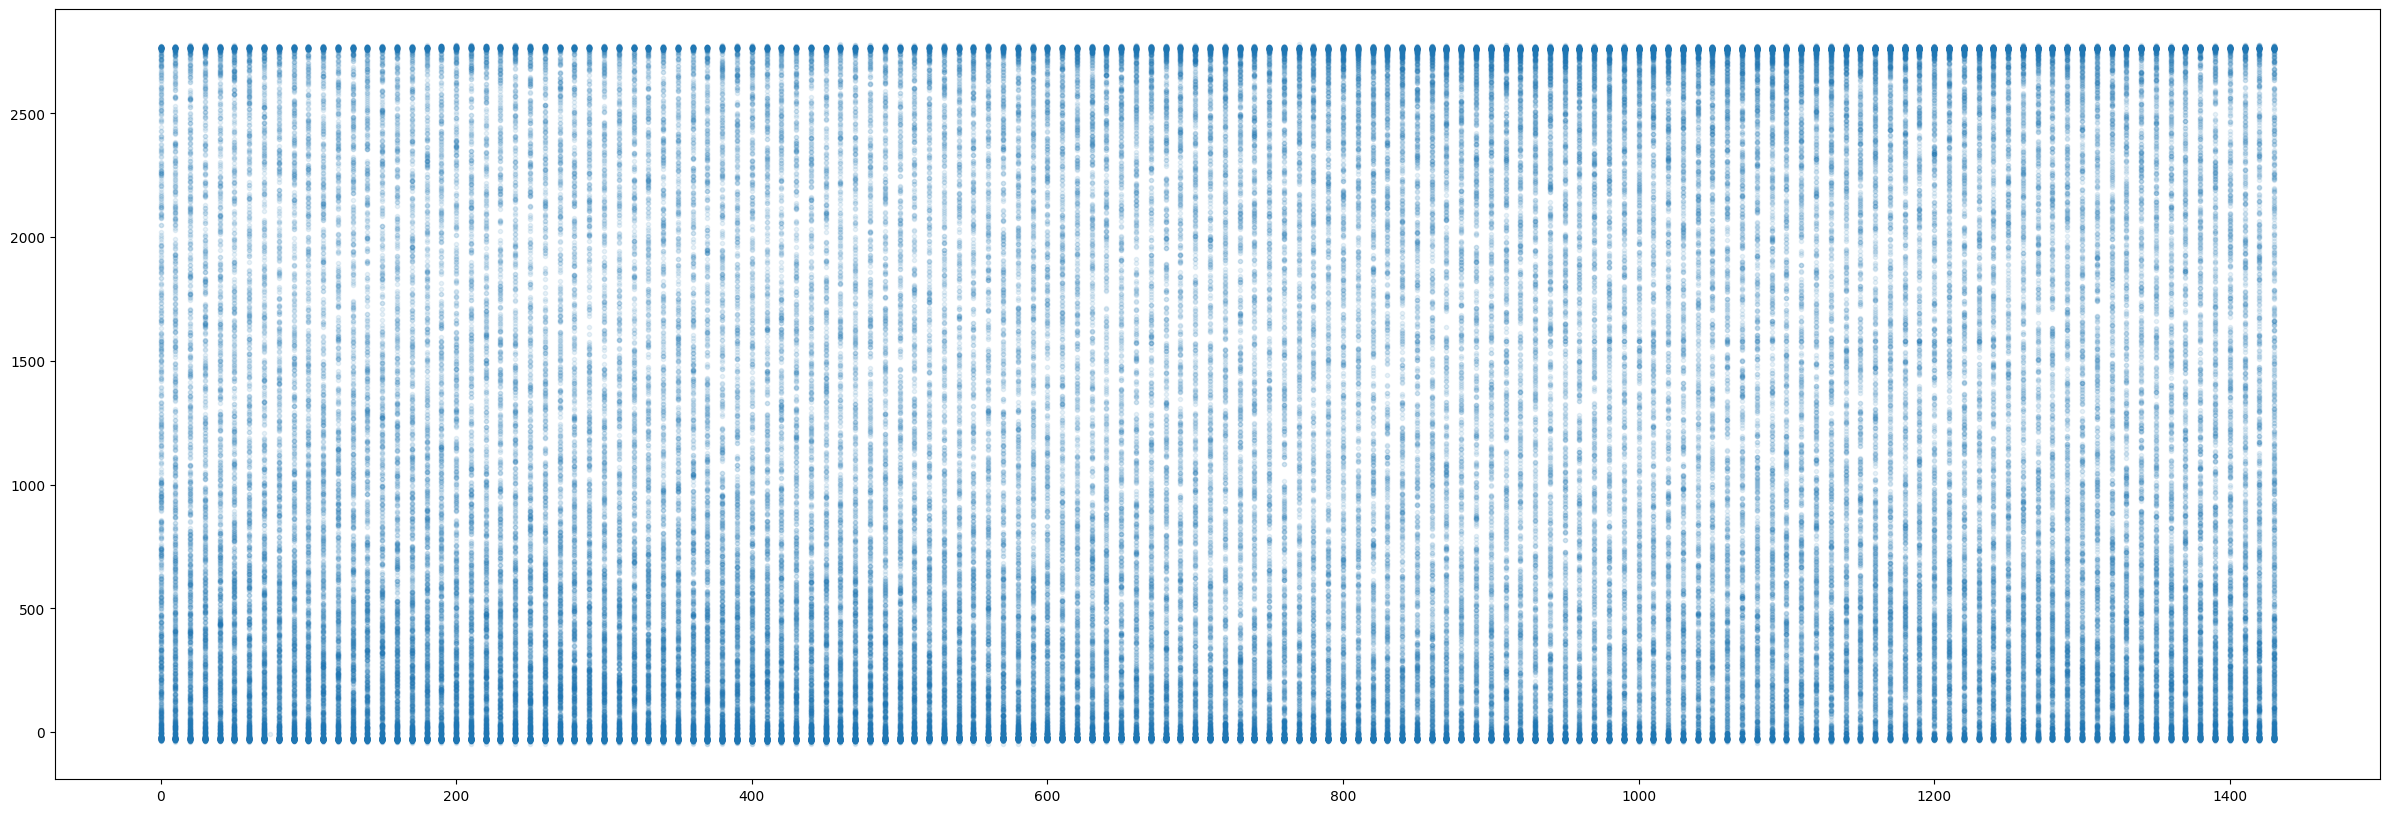

In [47]:
df_sample = df.sample(50000) 

plt.figure(figsize=(30, 10))
plt.scatter(df["minute_of_day"], df["Power(kW)"], alpha=0.1, marker=".")
plt.show()

In [43]:
sf_df = df[["Timestamp", "Power(kW)"]]
sf_df["unique_id"] = ["H1"]*len(df["Power(kW)"])

sf_df.rename(columns={"Timestamp": "ds", "Power(kW)": "y"}, inplace=True)

C:\Users\leopu\AppData\Local\Temp\ipykernel_3516\980493480.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sf_df["unique_id"] = ["H1"]*len(df["Power(kW)"])
C:\Users\leopu\AppData\Local\Temp\ipykernel_3516\980493480.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sf_df.rename(columns={"Timestamp": "ds", "Power(kW)": "y"}, inplace=True)


In [44]:
sf_df

,ds,y,unique_id
0,2019-01-01 00:00:00,705.876648,H1
1,2019-01-01 00:10:00,884.711670,H1
2,2019-01-01 00:20:00,982.875000,H1
3,2019-01-01 00:30:00,1115.943359,H1
4,2019-01-01 00:40:00,1263.841675,H1
...,...,...,...
154257,2021-12-14 23:10:00,NaN,H1
154258,2021-12-14 23:20:00,NaN,H1
154259,2021-12-14 23:30:00,NaN,H1
154260,2021-12-14 23:40:00,NaN,H1


In [49]:
models = [
    AutoARIMA(season_length=144),
]

In [52]:
sf = StatsForecast(
    df=sf_df[], 
    models=models,
    freq="H", 
    n_jobs=-1,
    fallback_model = SeasonalNaive(season_length=7)
)

In [53]:
forecasts_df = sf.forecast(h=48, level=[90])

forecasts_df.head()